## PREPROCESSING

Ricette definite in un formato semistrutturato, raggruppamento degli step e ingredienti in un unica stringa, funzioni di utilità

### Funzioni util e import

In [11]:
from pathlib import Path
import pandas as pd
from IPython.display import display
from ast import literal_eval
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.sem import relextract
import spacy
from nltk.corpus import conll2000

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('conll2000')


!python -m spacy download en_core_web_sm

spacy.load('en_core_web_sm')


def string_recipe(i):
    return dataset.iloc[i]['title'] + "\n\n" + dataset.iloc[i]['ingredients'] + "\n\n" + dataset.iloc[i]['step'] 

[nltk_data] Downloading package stopwords to /home/navis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/navis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/navis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/navis/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/navis/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/navis/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


     |████████████████████████████████| 13.9 MB 2.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Caricamento del dataset

In [3]:
dataset = pd.read_csv(
    Path("../data/test_dataset.csv").resolve(), 
    index_col=[0], 
    names=["index", "title","ingredients","step"], 
    usecols=[0,1,2,3]
    )

for index in range(len(dataset)):
    dataset.iloc[index]['ingredients'] = ".\n".join(literal_eval(dataset.iloc[index]['ingredients']))
    dataset.iloc[index]['step'] = " ".join(literal_eval(dataset.iloc[index]['step']))

display(dataset.head())
print(string_recipe(10))


,title,ingredients,step
index,,,
1,Jewell Ball'S Chicken,"1 small jar chipped beef, cut up.\n4 boned chi...",Place chipped beef on bottom of baking dish. P...
2,Creamy Corn,2 (16 oz.) pkg. frozen corn.\n1 (8 oz.) pkg. c...,"In a slow cooker, combine all ingredients. Cov..."
3,Chicken Funny,1 large whole chicken.\n2 (10 1/2 oz.) cans ch...,Boil and debone chicken. Put bite size pieces ...
4,Reeses Cups(Candy),1 c. peanut butter.\n3/4 c. graham cracker cru...,Combine first four ingredients and press in 13...
5,Cheeseburger Potato Soup,6 baking potatoes.\n1 lb. of extra lean ground...,Wash potatoes; prick several times with a fork...


Buckeye Candy

1 box powdered sugar.
8 oz. soft butter.
1 (8 oz.) peanut butter.
paraffin.
12 oz. chocolate chips

Mix sugar, butter and peanut butter. Roll into balls and place on cookie sheet. Set in freezer for at least 30 minutes. Melt chocolate chips and paraffin in double boiler. Using a toothpick, dip balls 3/4 of way into chocolate chip and paraffin mixture to make them look like buckeyes.


### Estrazione delle abbreviazioni

Fase iniziale di ritrovamento del set di abbreviazioni

In [4]:
abbrv_dataset = pd.read_csv(
    Path("../data/test_dataset.csv").resolve(), 
    index_col=[0], 
    names=["index", "title","ingredients","step"], 
    usecols=[0,1,2,3]
    )

abbrv = set()
for index in range(len(dataset)):
    abbrv_dataset.iloc[index]['ingredients'] = " ".join(literal_eval(abbrv_dataset.iloc[index]['ingredients']))
    for element in re.findall(r"[A-Za-z]*\.", abbrv_dataset.iloc[index]['ingredients']):
        abbrv.add(element)
    
print(abbrv)

{'Tbsp.', 'tsp.', 'c.', 'qt.', 'gal.', 'oz.', 'tbsp.', 'No.', 'pkg.', 'sq.', 'lb.', 'pt.'}


Rimozione delle abbreviazioni in quanto possono essere dannose per il processo di tokenizzazione. Es pkg. ---> package

In [6]:
def expand_abbreviations(ingredients_string):
    __ABBREVIATIONS__ = {
        'pkg.'  :   'package',
        'tsb.'  :   'tablespoon',
        'no.'   :   'number',
        'pt.'   :   'pint',
        'no.'   :   'number',
        'gal.'  :   'gallon',
        'tbsp.' :   'tablespoon',
        'sq.'   :   'square',
        'oz.'   :   'ounce',
        'lb.'   :   'pound',
        'qt.'   :   'quart',
        'c.'    :   'cup',
        'tsp.'  :   'teaspoon'
    }
    for item, value in __ABBREVIATIONS__.items():
        ingredients_string = ingredients_string.lower().replace(item, value)
    return ingredients_string


for index in range(len(dataset)):
    dataset.iloc[index]['ingredients'] = expand_abbreviations(dataset.iloc[index]['ingredients'])

### Sentence splitting
Il contenuto delle colonne 'ingredients' e 'step' verrà suddiviso in frasi. In precedenza i periodi contenuti nelle singole celle sono stati formattati in modo tale da renderli riconoscibili e facilmente suddivisibili in frasi ben separate.

In [8]:
for index in range(len(dataset)):
     dataset.iloc[index]['ingredients'] = (sent_tokenize(dataset.iloc[index]['ingredients']))
print(dataset.iloc[10]['ingredients'])

TypeError: expected string or bytes-like object

In [9]:
for index in range(len(dataset)):
     dataset.iloc[index]['step'] = (sent_tokenize(dataset.iloc[index]['step']))
print(dataset.iloc[10]['step'])

['Mix sugar, butter and peanut butter.', 'Roll into balls and place on cookie sheet.', 'Set in freezer for at least 30 minutes.', 'Melt chocolate chips and paraffin in double boiler.', 'Using a toothpick, dip balls 3/4 of way into chocolate chip and paraffin mixture to make them look like buckeyes.']


## ANALISI

### Stop words removal
Nella colonna 'step' troviamo una serie di passaggi da compiere per creare la ricetta. Questi passaggi sono scritti in linguaggio naturale e possono essere semplificati rimuovendo delle parole dette stop words.

In [68]:
# OPTINAL -> Risultati in swr_dataset"

stop_words = set(stopwords.words('english'))
swr_dataset = dataset.copy(deep=True)

tk = lambda x,st: ' '.join([w for w in x if w not in st])
for index in range(len(dataset)):
    swr_dataset.iloc[index]['step'] = [tk(word_tokenize(sent), stop_words) for sent in dataset.iloc[index]['step']]

### Stemming e Lemming
Questi due processi potrebbero portare valore all'analisi del dominio. Il codice per entrambi viene proposto qui.

In [69]:
# OPTINAL -> Risultati in lem_dataset"

lemmatizer = WordNetLemmatizer()
lem_dataset = swr_dataset.copy(deep=True)

for index in range(len(swr_dataset)):
    lem_dataset.iloc[index]['step'] = stem_sent = [' '.join([lemmatizer.lemmatize(w) for w in word_tokenize(sent)]) for sent in swr_dataset.iloc[index]['step']]

In [70]:
# OPTINAL -> Risultati in stm_dataset"

stemmer = PorterStemmer()
stm_dataset = lem_dataset.copy(deep=True)

for index in range(len(lem_dataset)):
    stm_dataset.iloc[index]['step'] = [' '.join([stemmer.stem(w) for w in word_tokenize(sent)]) for sent in lem_dataset.iloc[index]['step']]

In [71]:
print("Frasi originali\n")
print(dataset.iloc[10]['step'])
print("\nStop word removal\n")
print(swr_dataset.iloc[10]['step'])
print("\nStop word e lemming\n")
print(lem_dataset.iloc[10]['step'])
print("\nStop word lemming e stemming\n")
print(stm_dataset.iloc[10]['step'])

Frasi originali

['Mix sugar, butter and peanut butter.', 'Roll into balls and place on cookie sheet.', 'Set in freezer for at least 30 minutes.', 'Melt chocolate chips and paraffin in double boiler.', 'Using a toothpick, dip balls 3/4 of way into chocolate chip and paraffin mixture to make them look like buckeyes.']

Stop word removal

['Mix sugar , butter peanut butter .', 'Roll balls place cookie sheet .', 'Set freezer least 30 minutes .', 'Melt chocolate chips paraffin double boiler .', 'Using toothpick , dip balls 3/4 way chocolate chip paraffin mixture make look like buckeyes .']

Stop word e lemming

['Mix sugar , butter peanut butter .', 'Roll ball place cookie sheet .', 'Set freezer least 30 minute .', 'Melt chocolate chip paraffin double boiler .', 'Using toothpick , dip ball 3/4 way chocolate chip paraffin mixture make look like buckeye .']

Stop word lemming e stemming

['mix sugar , butter peanut butter .', 'roll ball place cooki sheet .', 'set freezer least 30 minut .', '

### POS-Tagging
Questa operazione ci permette di riconoscere le parti del testo. !!!Attualmente vengono solo stampate, ma in seguito le utilizzeremo a modo!!!

In [66]:
#POS-Tagging per gli ingredienti

for index in range(len(dataset)):
    for sent in dataset.iloc[index]['ingredients']:
        words = word_tokenize(sent)
        tagged = nltk.pos_tag(words)
        print(tagged)

[('1', 'CD'), ('small', 'JJ'), ('jar', 'NN'), ('chipped', 'VBD'), ('beef', 'NN'), ('cut', 'NN'), ('up', 'RP')]
[('4', 'CD'), ('boned', 'VBD'), ('chicken', 'NN'), ('breasts', 'NNS')]
[('1', 'CD'), ('can', 'MD'), ('cream', 'VB'), ('of', 'IN'), ('mushroom', 'NN'), ('soup', 'NN')]
[('1', 'CD'), ('carton', 'NN'), ('sour', 'NN'), ('cream', 'NN')]
[('2', 'CD'), ('16', 'CD'), ('ounce', 'NN'), ('package', 'NN'), ('frozen', 'JJ'), ('corn', 'NN')]
[('1', 'CD'), ('8', 'CD'), ('ounce', 'NN'), ('package', 'NN'), ('cream', 'NN'), ('cheese', 'NN'), ('cubed', 'VBD')]
[('1', 'CD'), ('3', 'CD'), ('cup', 'NN'), ('butter', 'NN'), ('cubed', 'VBD')]
[('1', 'CD'), ('2', 'CD'), ('teaspoon', 'NN'), ('garlic', 'JJ'), ('powder', 'NN')]
[('1', 'CD'), ('2', 'CD'), ('teaspoon', 'NN'), ('salt', 'NN')]
[('1', 'CD'), ('4', 'CD'), ('teaspoon', 'NN'), ('pepper', 'NN')]
[('1', 'CD'), ('large', 'JJ'), ('whole', 'JJ'), ('chicken', 'NN')]
[('2', 'CD'), ('10', 'CD'), ('1', 'CD'), ('2', 'CD'), ('ounce', 'NN'), ('cans', 'NNS'),

In [65]:
#POS-Tagging per gli step

for index in range(len(dataset)):
    for sent in dataset.iloc[index]['step']:
        words = word_tokenize(sent)
        tagged = nltk.pos_tag(words)
        print(tagged)

[('Place', 'NN'), ('chipped', 'VBD'), ('beef', 'NN'), ('on', 'IN'), ('bottom', 'NN'), ('of', 'IN'), ('baking', 'VBG'), ('dish', 'NN')]
[('Place', 'NNP'), ('chicken', 'NN'), ('on', 'IN'), ('top', 'NN'), ('of', 'IN'), ('beef', 'NN')]
[('Mix', 'NNP'), ('soup', 'NN'), ('and', 'CC'), ('cream', 'NN'), ('together', 'RB'), ('pour', 'NN'), ('over', 'IN'), ('chicken', 'NN')]
[('Bake', 'VB'), ('uncovered', 'VBN'), ('at', 'IN'), ('275', 'CD'), ('for', 'IN'), ('3', 'CD'), ('hours', 'NNS')]
[('In', 'IN'), ('a', 'DT'), ('slow', 'JJ'), ('cooker', 'NN'), ('combine', 'NN'), ('all', 'DT'), ('ingredients', 'NNS')]
[('Cover', 'NNP'), ('and', 'CC'), ('cook', 'VB'), ('on', 'IN'), ('low', 'JJ'), ('for', 'IN'), ('4', 'CD'), ('hours', 'NNS'), ('or', 'CC'), ('until', 'IN'), ('heated', 'VBN'), ('through', 'IN'), ('and', 'CC'), ('cheese', 'JJ'), ('is', 'VBZ'), ('melted', 'VBN')]
[('Stir', 'NNP'), ('well', 'RB'), ('before', 'IN'), ('serving', 'VBG')]
[('Yields', 'NNS'), ('6', 'CD'), ('servings', 'NNS')]
[('Boil', '

### [WIP] Entity Extraction and relation extraction

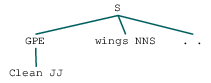

[[[], Tree('GPE', [('Clean', 'JJ')])]]
[] --> (GPE Clean/JJ)


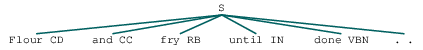

[]


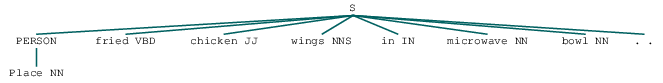

[[[], Tree('PERSON', [('Place', 'NN')])]]
[] --> (PERSON Place/NN)


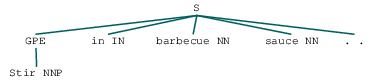

[[[], Tree('GPE', [('Stir', 'NNP')])]]
[] --> (GPE Stir/NNP)


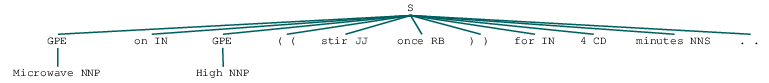

[[[], Tree('GPE', [('Microwave', 'NNP')])], [[('on', 'IN')], Tree('GPE', [('High', 'NNP')])]]
[] --> (GPE Microwave/NNP)
[('on', 'IN')] --> (GPE High/NNP)


In [22]:
example_string = dataset.iloc[11]['step']

for step in example_string:
    tpos = pos_tag(word_tokenize(step))
    ck = ne_chunk(tpos)
    relation = relextract.tree2semi_rel(ck)
    display(ck)
    print(relation)
    for s, tree in relation:
        print(s, "-->", tree)